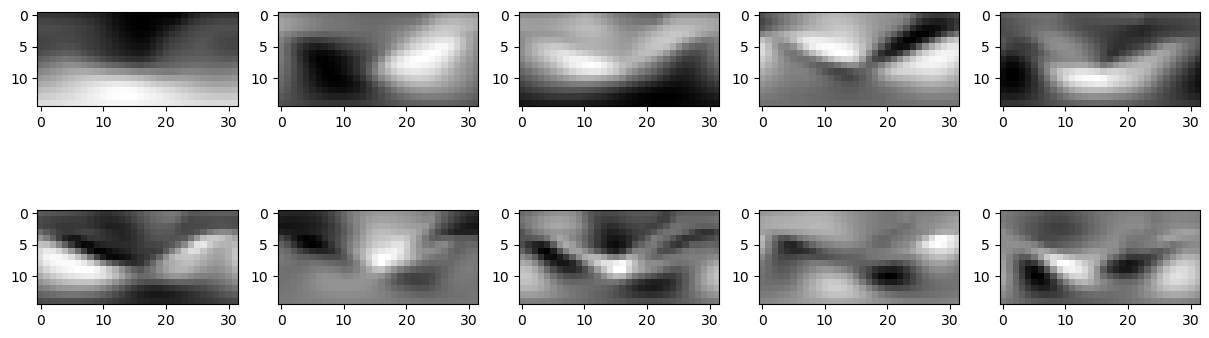

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from esn_dts_openloop import ESN, Tikhonov

def read_sw_data(file_name):
    dataa = np.empty(0)
    datab = np.empty(0)
    datac = np.empty(0)
    datad = np.empty(0)

    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            dataa = np.hstack((dataa, float(tmp[0])))  # by
            datab = np.hstack((datab, float(tmp[1])))  # bz
            datac = np.hstack((datac, float(tmp[2])))  # log10vx-2.5
            datad = np.hstack((datad, float(tmp[3])))  # log10np-1.0

    return dataa,datab,datac,datad

#with open('bigfac756n.dat') as f:
#with open('bigfac756n.dat') as f:
with open('bigpot756n.dat') as f:
    rectype = np.dtype(np.float32)
    dat = np.fromfile(f, dtype=rectype)

b=dat.reshape([756,15*32])

#pca = PCA()
#pca.fit(b)
#accumulated_ratio_ = np.add.accumulate(pca.explained_variance_ratio_)
#plt.plot(accumulated_ratio_)
#plt.xlim(0,30)
#plt.show()

pca = PCA(n_components=10)
pca.fit(b)
X_train_latent = pca.transform(b)
X_train_inv = pca.inverse_transform(X_train_latent)

plt.figure(figsize=(15,15))
for jj in range(0,10):
    plt.subplot(6,5,jj+1)
    plt.imshow(pca.components_[jj].reshape(15,32), cmap='gray')


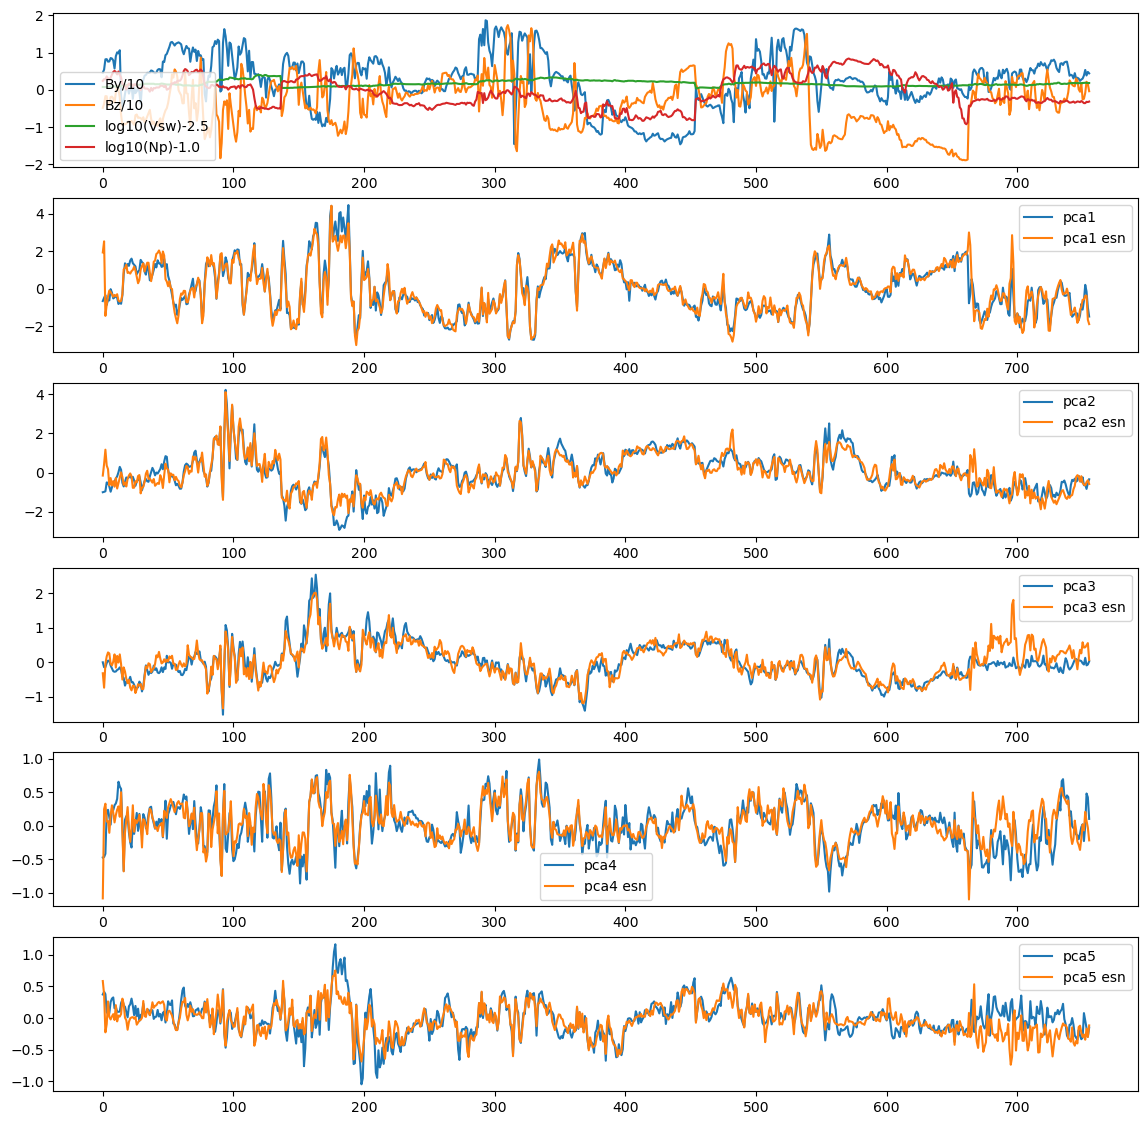

In [5]:
data_d = X_train_latent #output data

sw1,sw2,sw3,sw4 = read_sw_data(file_name='sw756.txt') #by,bz,v,n

all0 = np.vstack((sw1,sw2,sw3,sw4))

data_u = all0.T #input data
    
T_train = 663
    
train_U = data_u[:T_train]
train_D = data_d[:T_train]

N_x = 300

model = ESN(train_U.shape[1], train_D.shape[1], N_x, density=0.1,input_scale=0.1, rho=0.65)
       
train_Y = model.train(train_U, train_D, Tikhonov(train_U.shape[1], N_x, train_D.shape[1], 1e-3))

test_Y = model.predict(data_u)

fig = plt.figure(figsize=(14, 14))
    
ax1 = fig.add_subplot(611)
ax1.plot(data_u[:,0]/10, label='By/10')
ax1.plot(data_u[:,1]/10, label='Bz/10')
ax1.plot(data_u[:,2], label='log10(Vsw)-2.5')
ax1.plot(data_u[:,3], label='log10(Np)-1.0')
ax1.legend()

ax2 = fig.add_subplot(612)
ax2.plot(data_d[:,1], label='pca1')
ax2.plot(test_Y[:,1], label='pca1 esn')
ax2.legend()

ax3 = fig.add_subplot(613)
ax3.plot(data_d[:,2], label='pca2')
ax3.plot(test_Y[:,2], label='pca2 esn')
ax3.legend()

ax4 = fig.add_subplot(614)
ax4.plot(data_d[:,3], label='pca3')
ax4.plot(test_Y[:,3], label='pca3 esn')
ax4.legend()

ax5 = fig.add_subplot(615)
ax5.plot(data_d[:,4], label='pca4')
ax5.plot(test_Y[:,4], label='pca4 esn')
ax5.legend()

ax6 = fig.add_subplot(616)
ax6.plot(data_d[:,5], label='pca5')
ax6.plot(test_Y[:,5], label='pca5 esn')
ax6.legend()

plt.show()

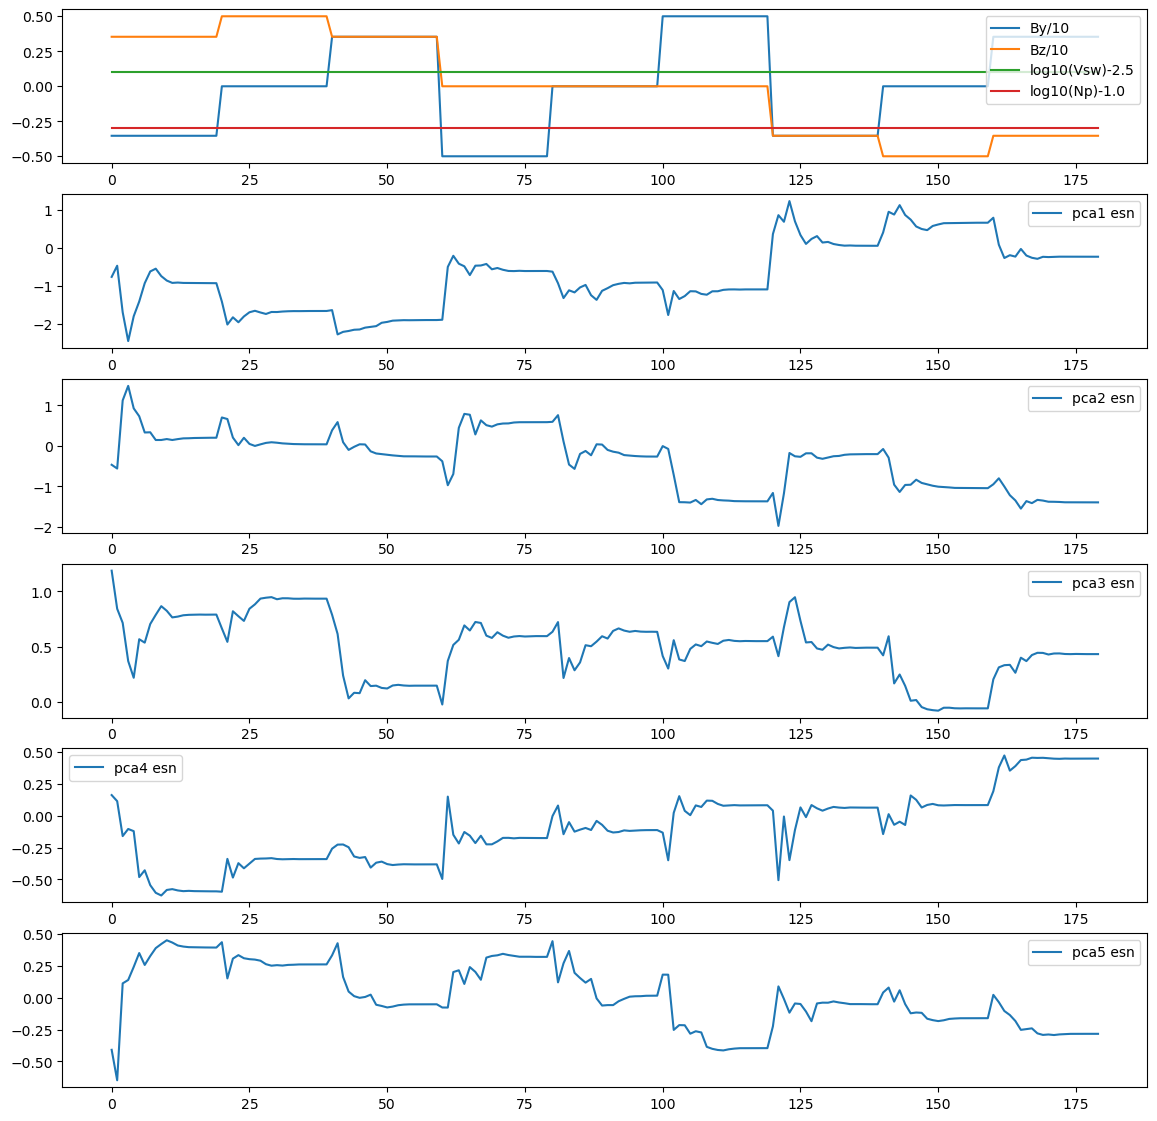

In [7]:
#synthetic solar wind data
sw10,sw20,sw30,sw40 = read_sw_data(file_name='synth_clock180.txt')
all10 = np.vstack((sw10,sw20,sw30,sw40))
data_s = all10.T

test_Y = model.predict(data_s)

fig = plt.figure(figsize=(14, 14))
    
ax1 = fig.add_subplot(611)
ax1.plot(data_s[:,0]/10, label='By/10')
ax1.plot(data_s[:,1]/10, label='Bz/10')
ax1.plot(data_s[:,2], label='log10(Vsw)-2.5')
ax1.plot(data_s[:,3], label='log10(Np)-1.0')
ax1.legend()

ax2 = fig.add_subplot(612)
ax2.plot(test_Y[:,1], label='pca1 esn')
ax2.legend()

ax3 = fig.add_subplot(613)
ax3.plot(test_Y[:,2], label='pca2 esn')
ax3.legend()

ax4 = fig.add_subplot(614)
ax4.plot(test_Y[:,3], label='pca3 esn')
ax4.legend()

ax5 = fig.add_subplot(615)
ax5.plot(test_Y[:,4], label='pca4 esn')
ax5.legend()

ax6 = fig.add_subplot(616)
ax6.plot(test_Y[:,5], label='pca5 esn')
ax6.legend()

plt.show()

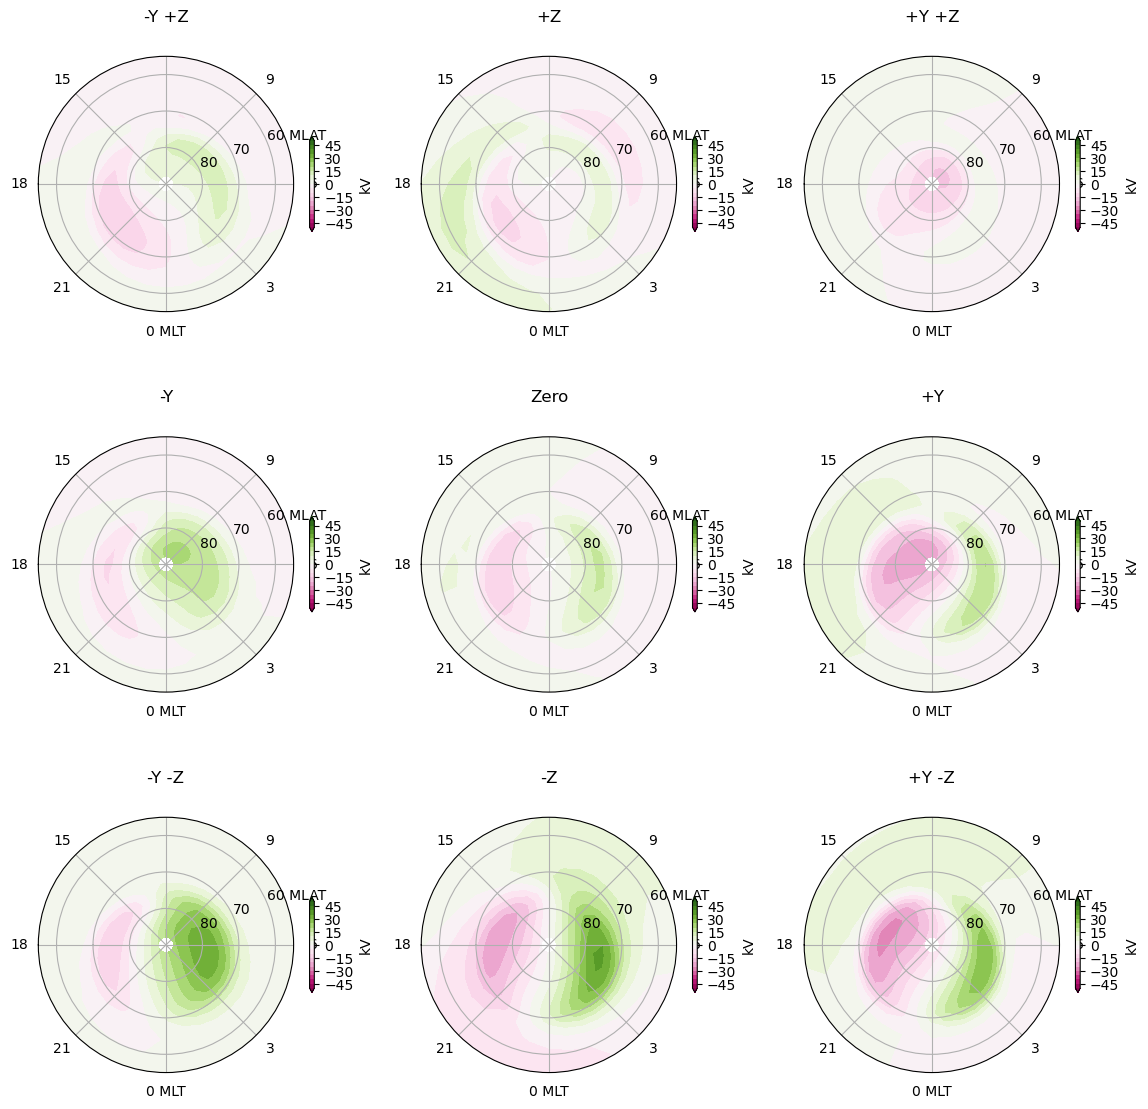

In [8]:
X_train_inv2 = pca.inverse_transform(test_Y)

f0 = -100 # factor for potential (kV)

fig = plt.figure(figsize=(14, 14))

theta=np.array([ 0.0, 11.25, 22.5, 33.75, 45.0, 56.25, 67.5, 78.75,
       90.0, 101.25, 112.5, 123.75, 135.0, 146.25, 157.5, 168.75, 
       180.0, 191.25, 202.5, 213.75, 225.0, 236.25, 247.5, 258.75, 
       270.0, 281.25, 292.5, 303.75, 315.0, 326.25, 337.5, 348.75, 360.0])
theta=theta-90.
theta=theta/360*np.pi*2

#north
r=np.array([51.5625, 55.6875, 59.8125, 63.9375, 67.0435, 69.1304, 71.2174,
            73.3044,75.3913, 77.4783, 79.5652, 81.6522, 83.7391, 85.8261, 87.9130])
r=90-r

tt, rr = np.meshgrid(theta,r) 

cb_min, cb_max,cb_div  = -50,50,20
interval_of_cf = np.linspace(cb_min, cb_max, cb_div+1)

iarr=np.arange(9)
ttlarr=["-Y +Z","+Z","+Y +Z","-Y","Zero","+Y","-Y -Z","-Z","+Y -Z",]

for i in iarr:

    iii=i*20+15
    
    ax=plt.subplot(3,3,i+1, polar=True)
    ax.set_title(ttlarr[i])
    ax.set_ylim([0,35])
    ax.set_yticks([10,20,30])
    ax.set_yticklabels(["80","70","60 MLAT"])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", " ", "15", "18"])
    z = X_train_inv2[iii].reshape(15,32) 

    z2=np.zeros((15,33))
    z2[:,0:32]=z
    z2[:,32]=z[:,0]

    ctf = plt.contourf(tt, rr, z2*f0,interval_of_cf, cmap="PiYG", extend="both")
    cbar=plt.colorbar(shrink=0.3,norm=ctf.norm, cmap=ctf.cmap)
    cbar.set_label('kV')
    
plt.show()